In [1]:
import os
import sys
sys.path.insert(0, '/Desktop/UCM_Undergraduate_Research/lib')
data_folder = '/Users/jocelynornelasmunoz/Desktop/UCM_Undergraduate_Research/data/'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn

# Read data sets from pickle files

Each dataset has shape `[60000, image_size, image_size, 1]`, where `image_size` is the size of the image (28,14,7,4)

In [2]:
image_sizes = [28, 14, 7, 4]
data28 = pd.read_pickle(data_folder + '28x28/X_train_28.pickle')
data14 = pd.read_pickle(data_folder + '14x14/X_train_14.pickle')
data7  = pd.read_pickle(data_folder + '7x7/X_train_7.pickle')
data4  = pd.read_pickle(data_folder + '4x4/X_train_4.pickle')

In [ ]:
data_names= ['data28', 'data14', 'data7', 'data4']

plt.imshow(data28[0,:,:,0]);plt.show()
plt.imshow(data14[0,:,:,0]);plt.show()
plt.imshow(data7[0,:,:,0]);plt.show()
plt.imshow(data4[0,:,:,0]);plt.show()

# Example with MNIST
The following example follows [PyTorch Convolution Article](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) and the `image_classifier_tutorial` jupyter notebook.

# Load PyTorch MNIST dataset

In [3]:
# define set of transformations to be done to the data
# - Normalize with mean 0, sd 1

transform = torchvision.transforms.Compose([
        #torchvision.transforms.Resize(14,14),
        torchvision.transforms.Normalize(0, 1)]) 

In [4]:
# define training and testing datasets
train_data = torchvision.datasets.MNIST(
    root = '../jornelasmunoz/data/',
    train = True,                         
    transform = transform, 
    download = True,            
)
test_data = torchvision.datasets.MNIST(
    root = '../jornelasmunoz/data/', 
    train = False, 
    transform = transform
)

100.1%

Extracting ../jornelasmunoz/data/MNIST/raw/train-images-idx3-ubyte.gz to ../jornelasmunoz/data/MNIST/raw


113.5%

Extracting ../jornelasmunoz/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../jornelasmunoz/data/MNIST/raw


100.4%

Extracting ../jornelasmunoz/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../jornelasmunoz/data/MNIST/raw


180.4%

Extracting ../jornelasmunoz/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../jornelasmunoz/data/MNIST/raw
Processing...
Done!


In [5]:
print('Training data    size: ', train_data.data.size())
print('Training targets size: ', train_data.targets.size())

Training data    size:  torch.Size([60000, 28, 28])
Training targets size:  torch.Size([60000])


### Plot multiple training data examples

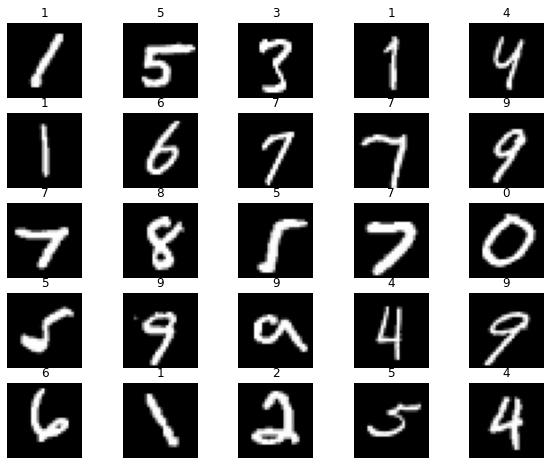

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data.data[sample_idx], train_data.targets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# dictionary stores DataLoaders for training and testing
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7facea787ac0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7facd6ffd400>}

# Define CNN Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''
        Goes through two layers of 2D convolutions, each followed by a 2x2 max pooling
        
        Dimensions:
        1.) Input Shape:          [batch_size, 1, 28, 28]
        
        2.) After conv:           [batch_size, 16, 24, 24]
            After max pooling:    [batch_size, 32, 12, 12]
        
        3.) After conv:           [batch_size, 16, 12, 12]
            After max pooling:    [batch_size, 32, 4, 4]
            
        4.) After flattening:     [batch_size, 32 * 4 * 4]
        '''
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 4 * 4, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 4 * 4)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [9]:
# Define CNN from newly defined class
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=512, out_features=10, bias=True)
)


### Define hyperparameters (Loss and Optimizer)

- Might be useful to do the parameters in a dictionary later
- loss, optimizer, number of epochs

In [10]:
loss_func = nn.CrossEntropyLoss(); print(loss_func)   
optimizer = torch.optim.Adam(cnn.parameters(), lr= 1e-5); print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


In [11]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
    
train(num_epochs, cnn, loaders)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py", line 97, in __getitem__
    img = self.transform(img)
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 70, in __call__
    img = t(img)
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 175, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/Users/omardeguchy/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py", line 210, in normalize
    raise TypeError('tensor is not a torch image.')
TypeError: tensor is not a torch image.
